## Previsão de UTI para Pacientes com Covid-19

<img src="https://img.olhardigital.com.br/wp-content/uploads/2019/12/20191219064913-1207x450.jpg">

## 1. Introdução

Este projeto de ciência de dados tem como objetivo desenvolver um modelo preditivo para detectar<b> quais pacientes precisarão ser admitidos na UTI</b>, a partir dos dados clínicos individuais do histórico de pacientes atendidos com <b>COVID-19</b>. O dados que serão utilizados neste projeto foram disponilizados pelo <b>Hospital Sírio Libanês - São Paulo e Brasília</b> no [Kaggle](https://www.kaggle.com/) (plataforma de competição de ciência de dados muito conhecida). Este modelo apoiará o hospital na organização e otimização quanto à disponibilidade de leitos para pacientes com COVID-19. Desta forma, a remoção e transferência deste(a) paciente pode ser organizada antecipadamente, evitando a ruptura, e assim, ajudando a <b>salvar vidas</b>.

## 2. Descrição dos Dados

Conforme falado anteriormente, o dataset que utilizaremos para desenvolvimento do modelo são dados clinícos individualizados de pacientes atendidos com COVID-19, disponbilizado pelo <b>Hospital Sírio Libanês</b>. E podemos baixar no portal do Kaggle neste [link](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

#### <b>Características dos Dados:</b>

- Informações demográficas do paciente (03 colunas)
- Doenças anteriores agrupadas de pacientes (09 colunas)
- Resultados de sangue (36 colunas)
- Sinais vitais (06 colunas)

No total são 54 colunas, expandidas quando pertinente à média, mediana, max, min, diff e diff relativo.

- <b>diff</b> = max - min: diferença entra valor máximo e mínimo da medida.
- <b>diff relativo</b> = diff / mediana (diferença dividido pela mediana).


No dataset há uma coluna chamada <b>WINDOW</b>, que utiliza o conceito de Janela, para trazer informações clínicas no período de tempo em que o paciente foi admitido: 

<table>
    <tr><td><b>Janela</b></td><td><b>Descrição</b><td></tr>
    <tr><td>0-2</td><td>De 0 a 2 horas da admissão</td>
    <tr><td>2-4</td><td>De 2 a 4 horas da admissão</td>
    <tr><td>4-6</td><td>De 4 a 6 horas da admissão</td>
    <tr><td>6-12</td><td>De 6 a 12 horas da admissão</td>
    <tr><td>Acima de 12</td><td>Acima de 12 horas a partir da admissão</td>
</table>

## 3. Analise Exploratória

### 3.1. Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

sns.set() # Setar a utilização do seaborn para demonstrar o gráfico.
sns.set_style('whitegrid')
sns.set_palette('rainbow')

### 3.2. Carregamento dos Dados

Para o carregamento dos dados utilizaremos ``read_excel`` do pandas, uma vez que os dados então em um arquivo <b>excel</b>.

In [2]:
df = pd.read_excel('https://github.com/diogoslz/Bootcamp-Alura-Modulo-Projeto-final/blob/main/Dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')

In [3]:
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [5]:
df.shape

(1925, 231)

Ao executar a função ``info`` e ``shape`` em nosso dataframe observamos algumas informações:

- 1925 linhas.
- 231 colunas:
    - 225 do tipo <b>float64</b> (dados contínuos)
    - 4 do tipo <b>inteiro</b> (dados contínuos ou binários)
    - 2 do tipo <b>object</b> (dados categóricos)
- O nome da primera coluna é: <b>PATIENT_VISIT_IDENTIFIER</b> 
- O nome da ultima coluna é: <b>ICU</b>

In [6]:
df.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Para analisar algumas informações estatísticas dos nossos dados, como <b> frequência (count), média (mean), desvio padrão (std), max, min e quartis</b>, utilizamos o método ```describe``` do pandas em nosso dataframe. Por padrão, o método retorna informações dos dados contínuous, por este motivo que não observamos informações dos dados categóricos, como o <b> AGE_PERCENTIL</b>.

In [7]:
print(list(df.columns))

['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN', 'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CALCIUM_DIFF', 'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATI

Acima listamos todas as colunas em nosso dataframes, total de <b>229 colunas</b>. Então observamos que o dataframe contém informações clínicas dos pacientes com COVID-19:

<b>Informações demográficas do paciente (03 colunas):</b>
- <b>Idade Acima de 65 Anos (AGE_ABOVE65)</b>
- <b>Faixa Etária (AGE_PERCENTIL)</b>
- <b>[Genêro](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19/discussion/164019) (GENDER)</b>
    0: Masculino
    1: Feminina

<b>Doenças anteriores agrupadas de pacientes (09 colunas):</b>
- <b>Grupo de Doenças 1 (DISEASE GROUPING 1)</b>
- <b>Grupo de Doenças 2 (DISEASE GROUPING 2)</b>
- <b>Grupo de Doenças 3 (DISEASE GROUPING 3)</b>
- <b>Grupo de Doenças 4 (DISEASE GROUPING 4)</b>
- <b>Grupo de Doenças 5 (DISEASE GROUPING 5)</b>
- <b>Grupo de Doenças 6 (DISEASE GROUPING 6)</b>
- <b>Hipertensão (HTN)</b>
- <b>Imunocomprometido (IMMUNOCOMPROMISED)</b>
- <b>Outros (OTHER)</b>

<b>Sinais vitais (6 colunas):</b> 
- <b>Saturação do Oxigênio (OXYGEN_SATURATION)</b>; 
- <b>Frequência Respiratória (RESPIRATORY_RATE)</b>;
- <b>Temperatura (TEMPERATURE)</b>;
- <b>Pressão Sistólica (BLOODPRESSURE_SISTOLIC);</b>
- <b>Pressão Diatolica (BLOODPRESSURE_DIASTOLIC);</b>.
- <b>Frequência Cardíaca (HEART_RATE);</b> 

<b>Exames de sangue (36 colunas):</b>

- <b>Glicose (GLUCOSE)</b>
- <b>Linfócitos (LINFOCITOS)</b>
- <b>PCR</b>
- <b>Creatinina (CREATININ)</b>
- ETC...

### 3.3. Preenchendo Dados Faltantes

<AxesSubplot:>

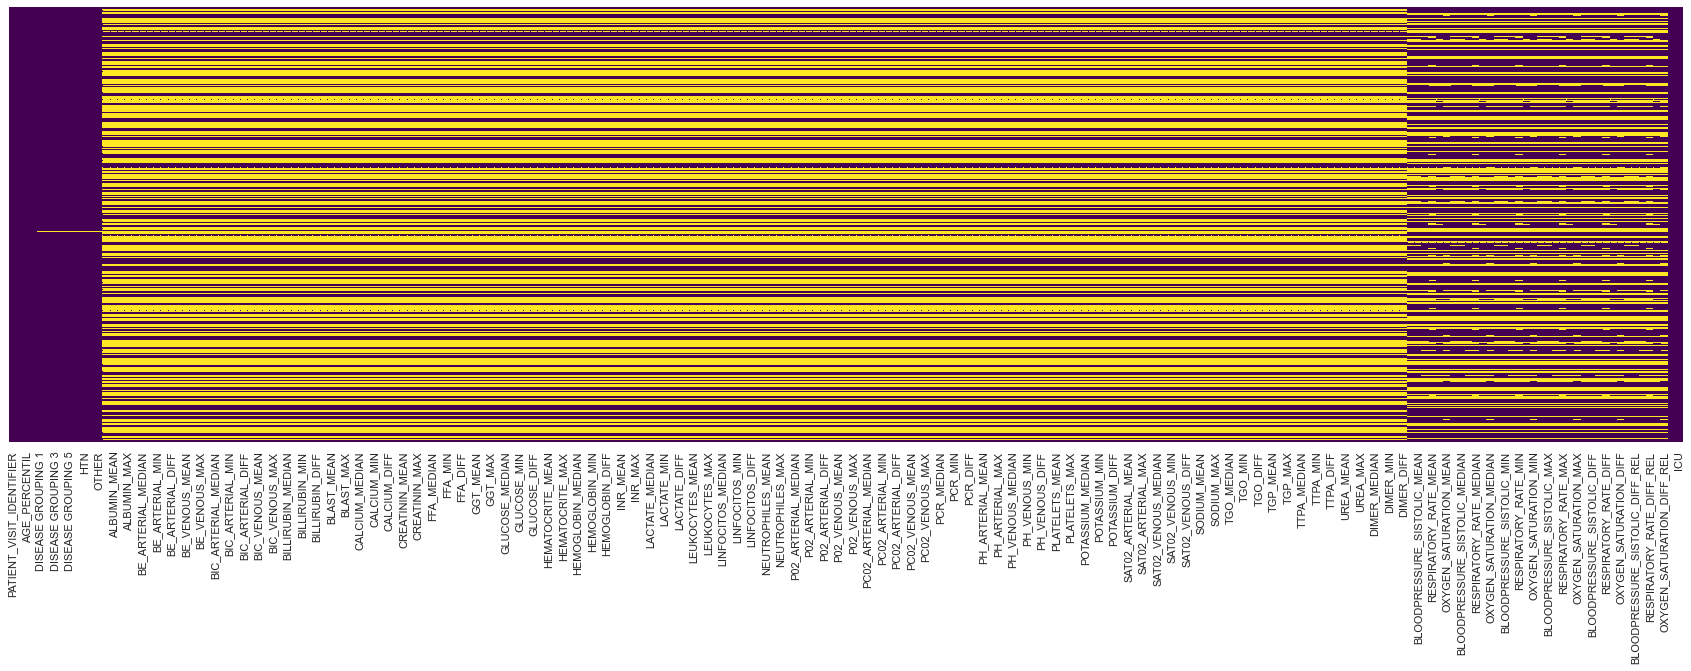

In [8]:
plt.figure(figsize=(30,8))

sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Utilizamos o método ```isnull``` do <b>Pandas</b> com  ```heatmap``` do <b>Seaborn</b> para visualizarmos os dados faltantes. Ao gerar o gráfico acima podemos visualizar destacado de amarelo as partes dos dados ausentes em nosso dataframe, o que evidencia uma grande quantidade de dados faltantes.

In [9]:
def preenchertabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas , saida], ignore_index=True, axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

Ao verificar o gráfico acima, percebemos que somente os dados contínuos estão vazios, ou seja, não temos informações de <b>sinais vitais e exames de sangue em janelas de vários pacientes</b>. 

Para desenvolvermos um modelo, precisaremos que todos os dados vazios sejam <b>preenchidos</b>, e como temos poucos dados para o desenvolvimento do modelo, não podemos simplesmente excluir todas as linhas dos dados vazios com método `dropna` do pandas, podendo afetar negativamente as <b>métricas</b> de avaliação do modelo. 

Neste caso específico, como são dados clínicos, é muito improvável que valores medidos da <b> pressão, ou frequência cardíaca</b> mudem repentinamente para outro valor muito diferente, em janelas próximas. Então, podemos deduzir que é <b>alta a probabilidade das informações de exames e sinais vitais coletados em janelas próximas de cada paciente sejam iguais, ou seja, são dados altamente dependentes e por isso repetiremos os dados faltantes com as informações da janela mais próxima</b>.

Para resolver esse problema:
- Criaremos uma função para separar os dados em: colunas contínuas, categóricas e saída. 
- Em seguida, tratamos os dados contínuos já separados com `fillna` com parâmetro method `bfill`, onde ele preenche a medida vazia anterior repetindo a medida posterior. 
- Também utilizamos o `fillna` com parâmetro method `ffill`, onde ele peenche a medida vazia posterior repetindo a medida anterior.

In [10]:
df_limpos = preenchertabela(df)
df_limpos = df_limpos.dropna()

<AxesSubplot:>

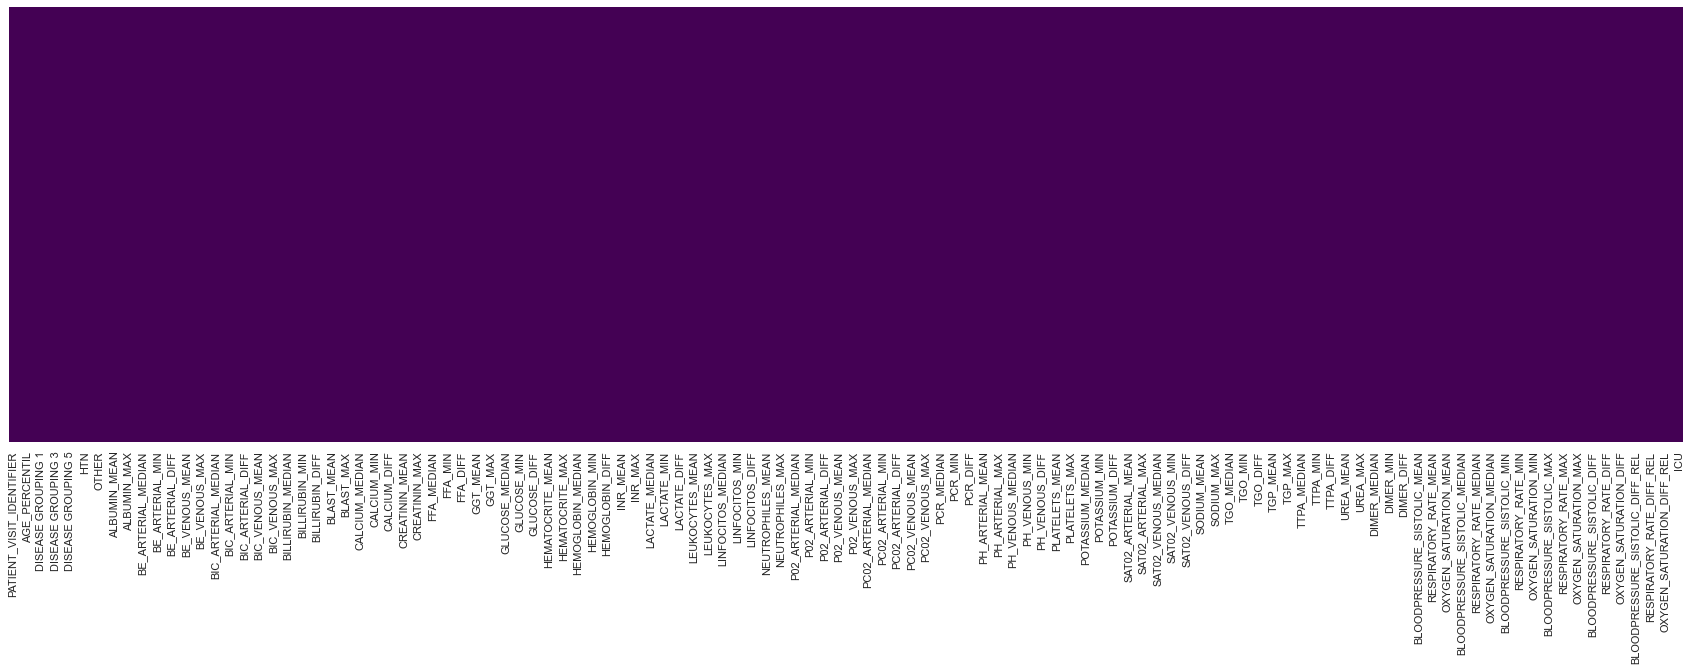

In [11]:
plt.figure(figsize=(30,8))

sns.heatmap(df_limpos.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Pronto! Ao visualizar novamente os dados com o gráfico ``heatmap`` com ``isnull``, percebemos que não existe mais partes destacados de amarelo no gráfico, o que demonstra que não existem dados faltantes em nosso dataframe.

### 3.4. Levantamento de Hipóteses

<img src="https://media1.tenor.com/images/4c6187594727c6937f0ed9c4cbaf7249/tenor.gif?itemid=8949118">

Antes da análise exploratória, vamos levantar algumas hipóteses de como a evolução do quadro clínico de pacientes – registrado nos exames laboratoriais e sinais vitais, coletados durante o período de internação – influenciou na internação em UTI (ICU).

É de comum conhecimento que existe um grupo de risco COVID-19 e esse grupo envolve pessoas com <b>mais idade, obesas (ou com péssimos hábitos alimentares) e doenças crônicas (como Diabéticos, Hipertensos, Imunodeficientes...)</b>. Para a nossa "sorte", essas informações foram disponiblizados pelo Hospital Sírio Libanês. Com isso em mente podemos levantar algumas perguntas:

1. <b>Pessoas com mais idade tem mais tendência a ir para a UTI?</b>
2. <b>Qual grupo de risco é mais propenso?</b>
3. <b>Existe um genêro predominante de pacientes indo para a UTI?</b>
4. <b>Os resultados dos exames laboratoriais tem correlação com ida da pessoas para a UTI?</b>

Com essas perguntas em mente, podemos desenvolver a análise explorátória para respondê-las.

### 3.5. Análise

Então vamos começar a análise exploratória! Começaremos pelas informações demográficas dos pacientes por COVID-19: <b>AGE_PERCENTIL, GENDER e AGE_ABOVE65.</b>

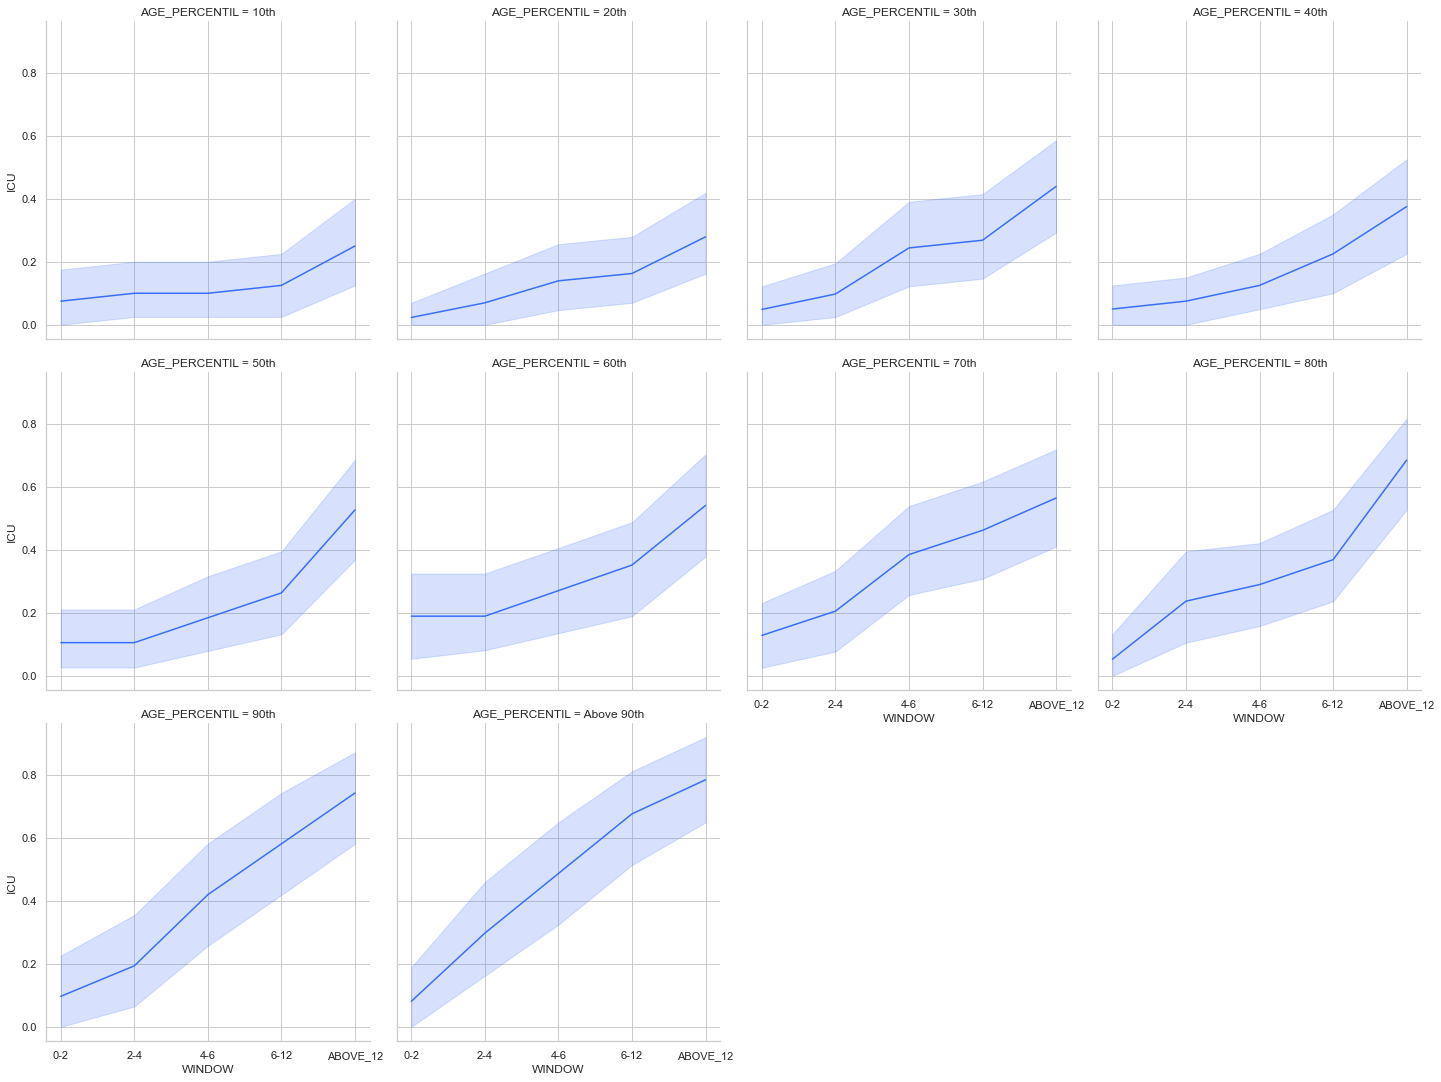

In [12]:
sns.relplot('WINDOW','ICU',col='AGE_PERCENTIL', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['AGE_PERCENTIL','WINDOW']))
plt.show()

Visualizando para o gráfico **RelPlot** acima, podemos facilmente inferir que a chance de **Pacientes na Faixa Etária acima de 90 anos** de serem internadas na UTI depois das **12 primeiras horas internação** é de cerca de **79-80%**.

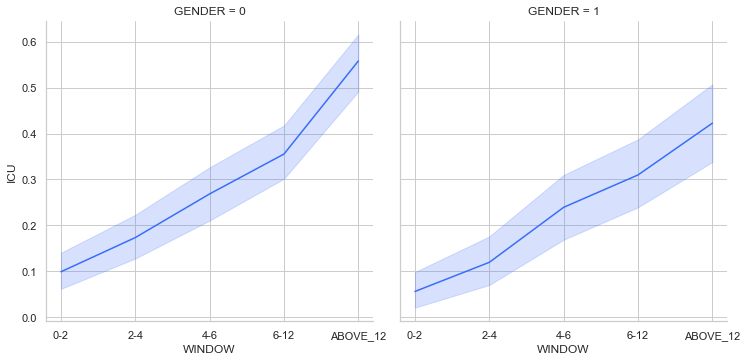

In [13]:
sns.relplot('WINDOW','ICU',col='GENDER', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['GENDER','WINDOW']))
plt.show()

Neste outro gráfico, podemos visualizar que ao passar do tempo de internação, a chance de **pacientes do Genêro Masculo** chega a ser de **56%** depois das 12 horas de internação. Comparado com **pacientes do Genêro Feminimo, as chances são 14% maior**.

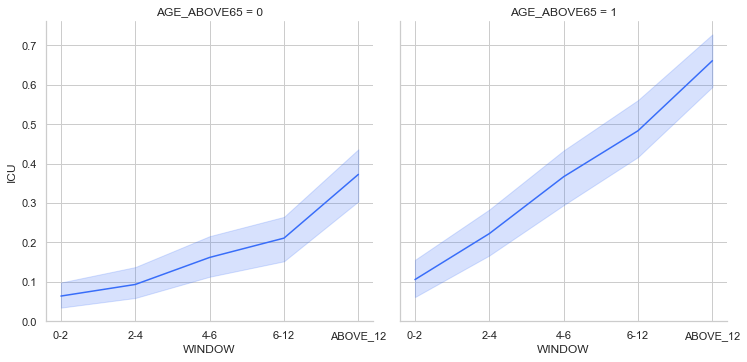

In [14]:
sns.relplot('WINDOW','ICU',col='AGE_ABOVE65', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['AGE_ABOVE65','WINDOW']))
plt.show()

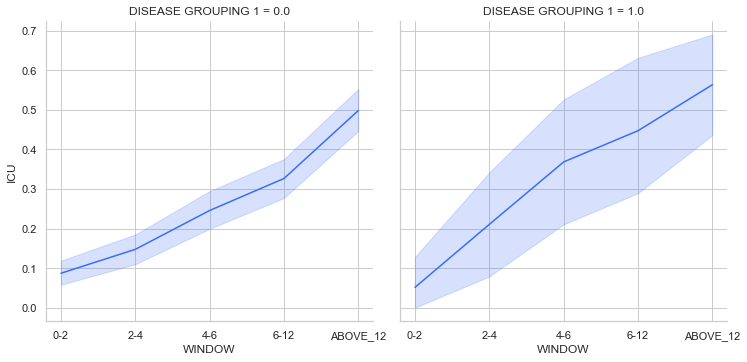

In [15]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 1', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 1','WINDOW']))
plt.show()

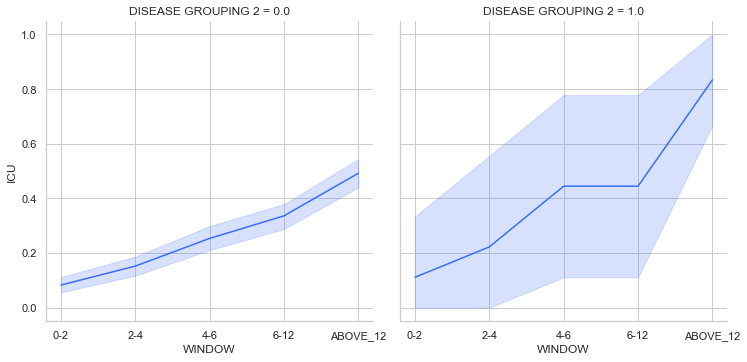

In [16]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 2', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 2','WINDOW']))
plt.show()

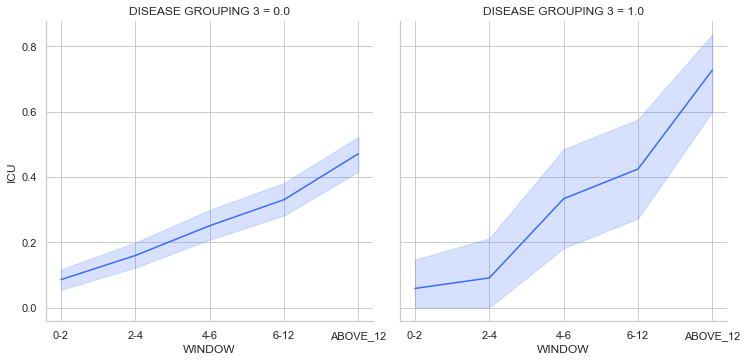

In [17]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 3', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 3','WINDOW']))
plt.show()

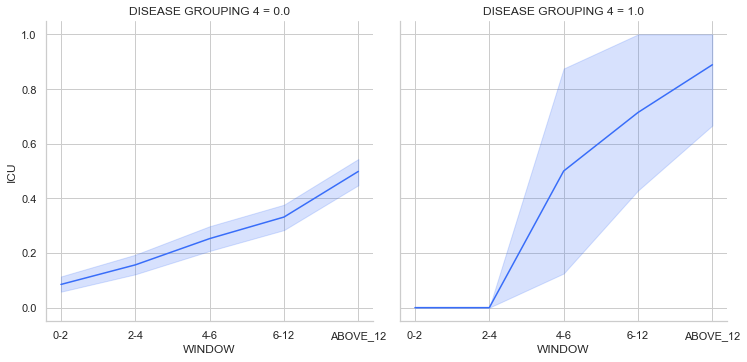

In [18]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 4', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 4','WINDOW']))
plt.show()

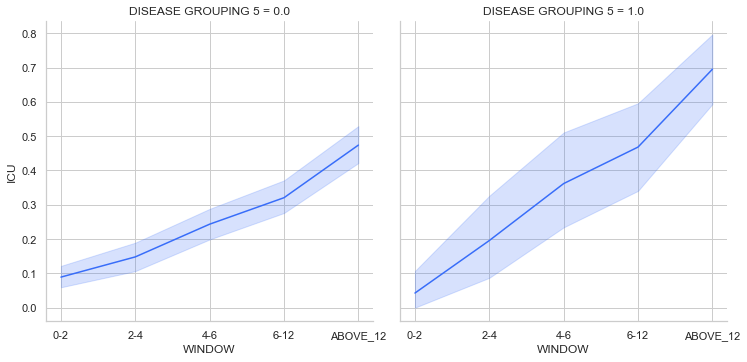

In [19]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 5', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 5','WINDOW']))
plt.show()

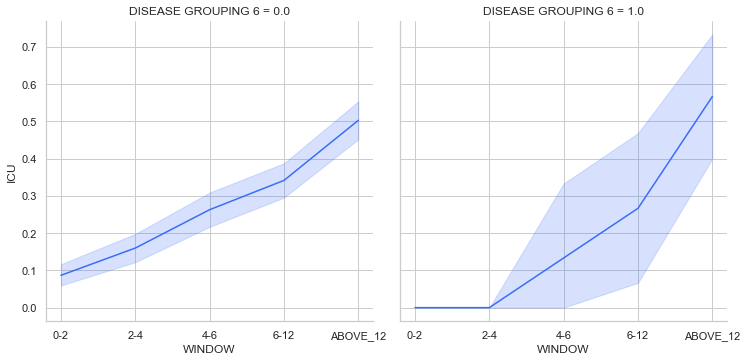

In [20]:
sns.relplot('WINDOW','ICU',col='DISEASE GROUPING 6', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['DISEASE GROUPING 6','WINDOW']))
plt.show()

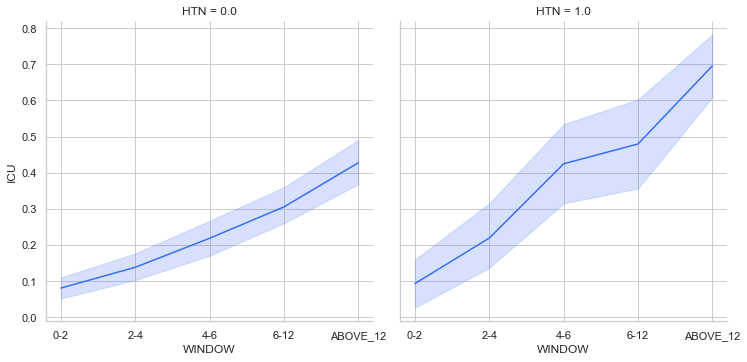

In [21]:
sns.relplot('WINDOW','ICU',col='HTN', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['HTN','WINDOW']))
plt.show()

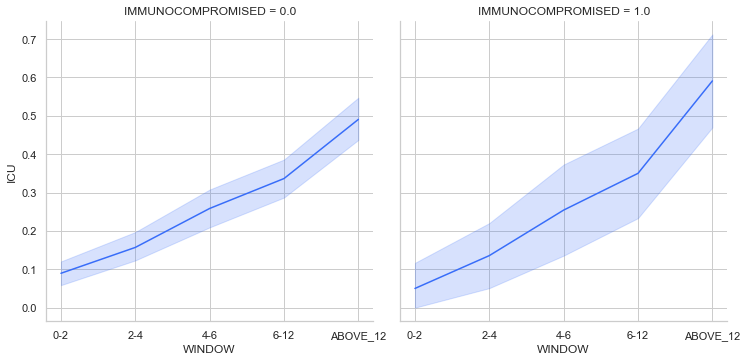

In [22]:
sns.relplot('WINDOW','ICU',col='IMMUNOCOMPROMISED', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['IMMUNOCOMPROMISED','WINDOW']))
plt.show()

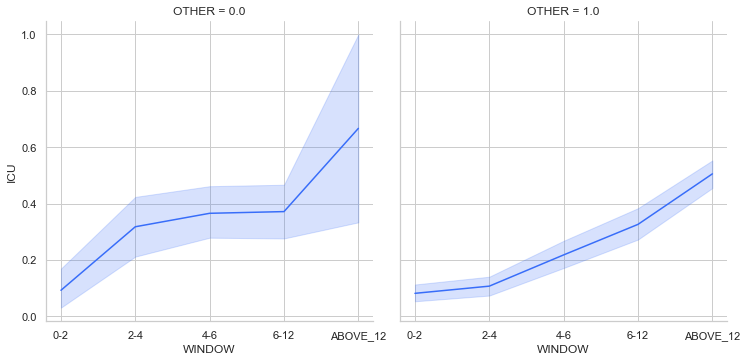

In [23]:
sns.relplot('WINDOW','ICU',col='OTHER', kind='line',col_wrap=4, data=df_limpos.sort_values(by=['OTHER','WINDOW']))
plt.show()

<AxesSubplot:>

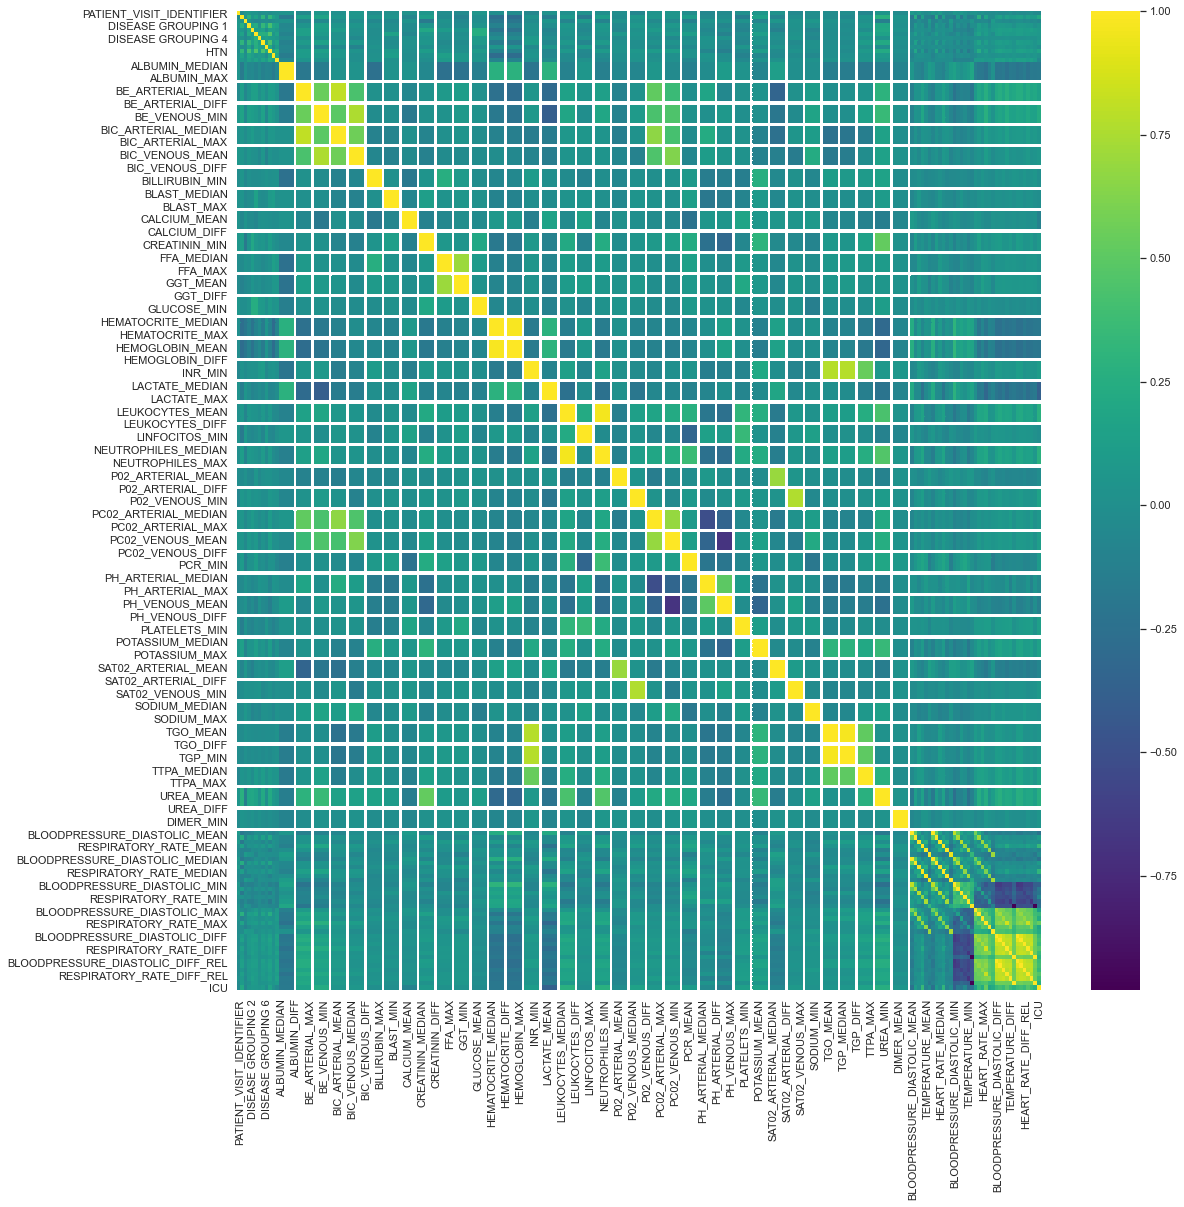

In [24]:
plt.figure(figsize=(18,18))

sns.heatmap(df_limpos.corr(),cmap='viridis')

Para analisarmos as correlações entre as variáveis, utilizamos o médodo `corr` em nosso dataframe e plotamos com`heatmap` do seaborn. Ao analisar o gráfico, percebemos fortes correlações (valores próximos de 1) entre as variáveis expandidas. Isso é natural, uma vez que são **de uma só origem**. Por exemplo: **OXYGEN_SATURATION_MIN, OXYGEN_SATURATION_MAX, OXYGEN_SATURATION_DIFF e OXYGEN_SATURATION_DIFF_REL**. Elas serão altamente correlacionáveis porque, no fim das contas, os valores dessas variáveis se originam da **Saturação do Oxigênio**.

Porém, ao visualizar o gráfico percebemos que as variáveis expandidas dificultam muito a nossa análise de correlações, pois, além de elevar a régua de correlação, o gráfico fica muito extenso devido ao **grande número de variáveis**. 

Para visualizarmos as correlações entre as informações de exames e sinais vitais, selecionamos **somente a Média** desses valores, utilizando o método `contains` nos nomes das colunas.

In [25]:
medias = df_limpos.columns.str.contains('MEAN')

In [26]:
analise_medias = df_limpos[df_limpos.columns[medias]]

analise_medias['ICU'] = df_limpos['ICU']
analise_medias.head()

,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,BLAST_MEAN,CALCIUM_MEAN,CREATININ_MEAN,FFA_MEAN,...,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,ICU
0,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,...,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0
1,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,...,-0.825613,-0.836145,-0.994912,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0
2,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,...,-0.825613,-0.836145,-0.994912,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,0
3,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,-1.0,0.326531,-0.926398,-0.859275,...,-0.846633,-0.836145,-0.996762,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,0
4,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,-1.0,0.326531,-0.926398,-0.859275,...,-0.846633,-0.836145,-0.996762,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,1


<AxesSubplot:>

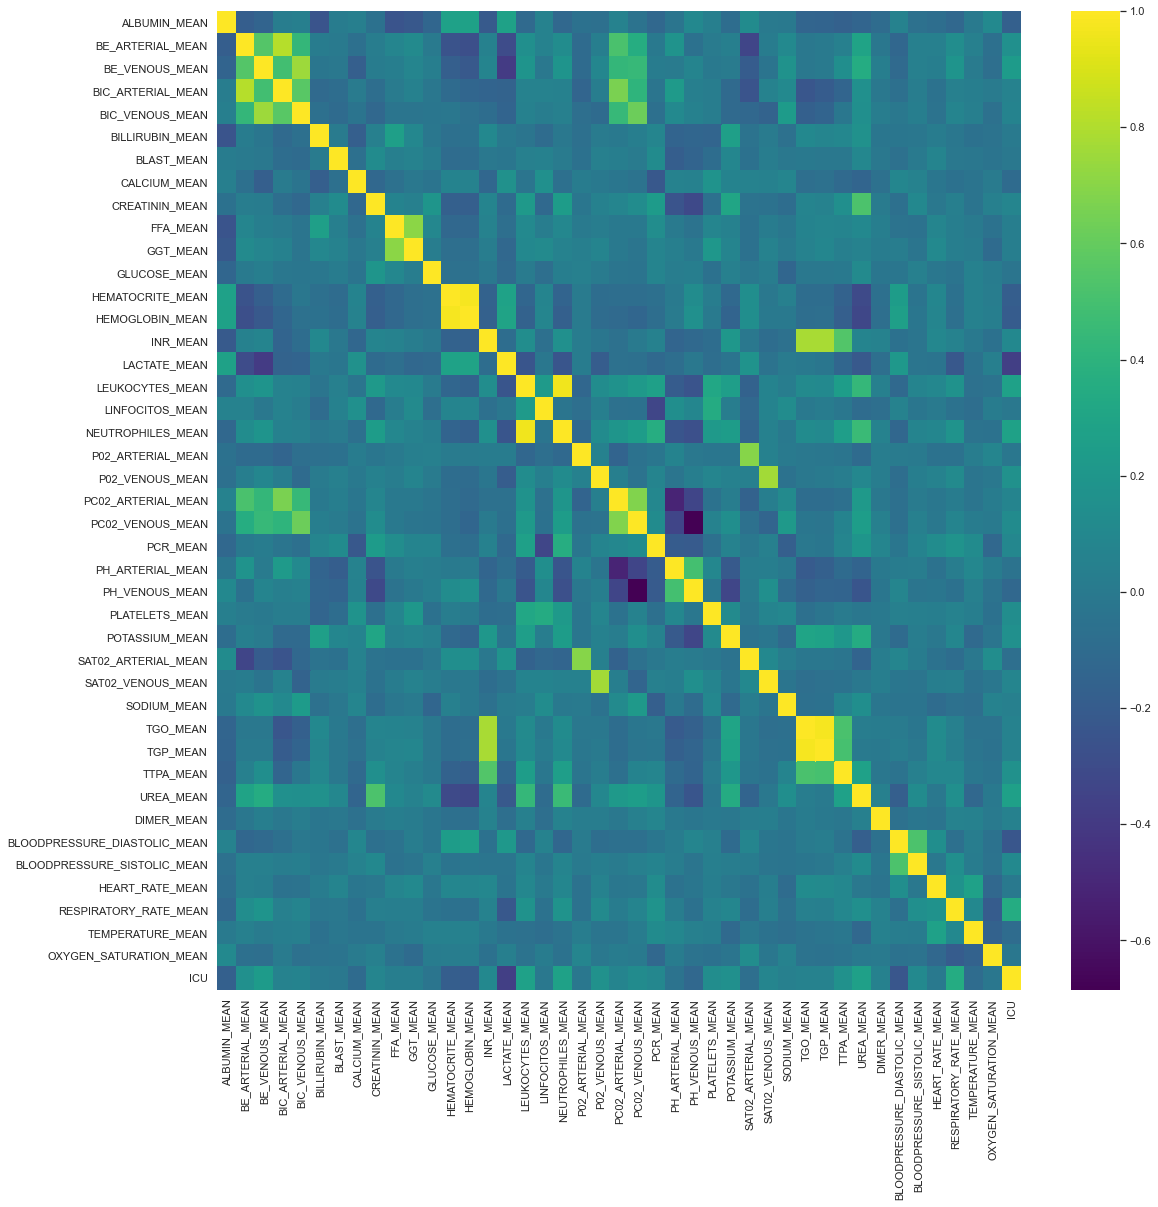

In [27]:
plt.figure(figsize=(18,18))

sns.heatmap(analise_medias.corr(),cmap='viridis')

In [28]:
analise_medias.corr()['ICU'].sort_values(ascending=False)

ICU                             1.000000
RESPIRATORY_RATE_MEAN           0.354464
NEUTROPHILES_MEAN               0.280044
LEUKOCYTES_MEAN                 0.274121
UREA_MEAN                       0.263455
BE_VENOUS_MEAN                  0.230357
TTPA_MEAN                       0.162953
P02_VENOUS_MEAN                 0.159333
POTASSIUM_MEAN                  0.152650
BE_ARTERIAL_MEAN                0.151272
PLATELETS_MEAN                  0.131564
PC02_VENOUS_MEAN                0.123445
BLOODPRESSURE_SISTOLIC_MEAN     0.109367
INR_MEAN                        0.104373
PCR_MEAN                        0.097697
SAT02_VENOUS_MEAN               0.084620
CREATININ_MEAN                  0.082518
PC02_ARTERIAL_MEAN              0.073401
BIC_VENOUS_MEAN                 0.068164
TGP_MEAN                        0.065025
TGO_MEAN                        0.054858
BIC_ARTERIAL_MEAN               0.054201
DIMER_MEAN                      0.049792
SODIUM_MEAN                     0.040294
GGT_MEAN        

Agora sim! Depois que selecionamos somente a MÉDIA, ficou mais fácil explorar as correlações entre as variáveis.

Ao analisar as correlações das váriaveis que correspondem aos **exames de sangue** e **sinais vitais**, com o nosso target para a previsão: **ICU**, percebemos que temos duas váriaveis que se destacam tanto positivamente quanto negativamente, respectivamente: a **Frequência Respiratória (RESPIRATORY_RATE_MEAN) com p igual a 0,35 e a LACTATE_MEAN com p igual a -0.36**. Com esses valores de p, podemos concluir que nenhuma variável correspondende a exames de sangue tem uma **correlação fraca** com o nosso target **ICU**.

Para melhor entendimento sobre correlação,  segue abaixo o trecho de um artigo muito bom sobre **Análise de correlação usando Python e R da [Amanda Munari Guimarães](https://medium.com/@amandamunariguimares)** no [Medium](https://medium.com/), para acessar basta clicar neste [link](https://medium.com/omixdata/estat%C3%ADstica-an%C3%A1lise-de-correla%C3%A7%C3%A3o-usando-python-e-r-d68611511b5a):

>Quando falamos em análise de dados, muitas vezes precisamos entender qual é a associação entre duas ou mais variáveis. Nesse caso, a análise de correlação é uma forma descritiva que mede se há e qual o grau de dependência entre variáveis, ou seja, o quanto uma variável interfere em outra. Lembrando que essa relação de dependência pode ou não ser causal. Essa medida de grau de relação é medida através de coeficientes. No caso deste post, nós vamos focar no coeficiente de Pearson.

>O coeficiente de Pearson, também chamado de “coeficiente de correlação produto-momento” ou chamado de “ρ de Pearson”, mede o grau de correlação através do cálculo de direção positiva ou negativa. Este coeficiente, normalmente representado por ρ assume apenas valores entre -1 e 1.

>A análise de correlação vai retornar três possíveis cenários: (1) correlação positiva; (2) correlação negativa; e (3) não há correlação.

>- **Correlação positiva:** quando duas variáveis que possuem correlação crescem ou decrescem juntas, ou seja, que possuem uma relação direta;
>- **Correlação negativa:** quando duas variáveis que possuem correlação mas quando uma variável cresce a outra decresce, ou vice-versa;
>- **Não ter correlação:** quando o crescimento ou decrescimento de uma variável não tem efeito sobre outra variável.
Como podemos interpretar os valores que ρ pode assumir?

>- **ρ = 0,9 a 1 (positivo ou negativo): correlação muito forte;**
>- **ρ = 0,7 a 0,9 (positivo ou negativo): correlação forte;**
>- **ρ = 0,5 a 0,7 (positivo ou negativo): correlação moderada;**
>- **ρ = 0,3 a 0,5 (positivo ou negativo): correlação fraca;**
>- **ρ = 0 a 0,3 (positivo ou negativo): não possui correlação.**

### 3.5. Seleção de Dados para Previsão

In [29]:
df_limpos[['PATIENT_VISIT_IDENTIFIER','WINDOW','ICU']].head()

,PATIENT_VISIT_IDENTIFIER,WINDOW,ICU
0,0,0-2,0
1,0,2-4,0
2,0,4-6,0
3,0,6-12,0
4,0,ABOVE_12,1


Como descrito e analisado anteriormente, percebemos que no dataframe que utilizaremos para a previsão, existe uma coluna chamada **WINDOW**, onde essa coluna registra as informações da janela de tempo em que o paciente está internado. Verificamos também que existe uma coluna **PATIENTE_VISIT_IDENTIFIER**, essa coluna registra a identificação do paciente. Isto é, em nosso dataframe contém informações da evolução clínica – com exames de sangue e sinais vitais – durante o período de internação.

Pensando nesse cenário, uma vez que temos que antecipar a ação do paciente antes de ir para a UTI, não faria sentido usar as informações clínicas depois que o paciente já foi internado na UTI para treinar o nosso modelo. Isso poderia deixá-lo **enviesado**, pois pode ocorrer do paciente ir direto para UTI **na primeira janela (pacientes com informações 0-2 na coluna WINDOW, com ICU igual a 1)**, e depois, ocorrer os exames de sangue e a coleta dos sinais vitais. Para os novos pacientes, com modelo já funcionando, ele não teria essas informações se o paciente for direto da UTI, já que a coleta foi depois.

Para evitar esse problema (e desenvolvermos um modelo que faça sentido), precisamos remover todos os pacientes que foram **direto para a UTI na primeira janela**. Para isso, selecionamos a coluna **PATIENTE_VISIT_IDENTIFIER** e utilizamos o método `query`+ `values` em nosso dataframe para selecionar somente os IDs dos pacientes na **janela 0-2** e **ICU igual a 1**, então guardarmos essa informação na variável `remover`.

In [30]:
remover = df.query("WINDOW == '0-2' and ICU == 1")['PATIENT_VISIT_IDENTIFIER'].values

In [31]:
remover

array([  1,  17,  27,  41,  47,  48,  54,  62,  85,  90, 104, 106, 109,
       117, 144, 176, 202, 206, 226, 233, 239, 261, 270, 282, 286, 306,
       315, 329, 359, 362, 366, 379], dtype=int64)

In [32]:
print('Total de pacientes que foram direto para UTI na primeira janela:', len(remover))

Total de pacientes que foram direto para UTI na primeira janela: 32


Com a lista de **IDs desses pacientes na váriável `remover`**, podemos utilizá-lo como parâmetro no método `query` para fazermos um `not in` (para não incluir) e então redefinimos o nosso dataframe `df_limpos` sem esses pacientes.

In [33]:
df_limpos = df_limpos.query("PATIENT_VISIT_IDENTIFIER not in  @remover")
df_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


Examinando os dados, me veio outra questão: **Devemos utilizar todas as janelas de tempo de um paciente para previsão?**

A análise exploratória já provou que quanto mais janelas utilizarmos para o treinamento do modelo, melhor será a precisão. 

**Porém, quanto mais antecipada a nossa previsão, mais valioso nosso modelo será para o Hospital Sírio Libanês**. Não concordas? Por este motivo, vamos selecionar somente as informações da primeira janela (inclusive, essa é uma dica dada pelo próprio hospital no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)). 

**Temos mais um porém aqui!** Se fizermos somente o filtro da primeira janela em nosso dataframe `df_limpos`, perderíamos todas as informações de pacientes que foram para UTI, uma vez que os excluímos logo na primeira janela. E não é isso que queremos.

Para tanto, criamos um método (`prepare_window`) que vai buscar em **todas as janelas (método `any` do numpy)** a informação na coluna **ICU** de que o paciente foi para a UTI (1: SIM ou 0: NÃO) e preencherá com esta informação a linha que representa a primeira **janela (até 2 horas de admissão)**. 

Para finalizar o método, selecionamos a linha que representa a primeira janela com a coluna **ICU já atualizada**. Com isso, teremos uma linha para cada paciente com informações da primera janela e, na coluna ICU a informação de que ele foi para **UTI preenchida**.

In [34]:
def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2','ICU'] = 1
    return rows.loc[rows['WINDOW']=='0-2']

In [35]:
df_limpos = df_limpos.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False ).apply(prepare_window)
df_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


### 3.6. Análise (Parte 2)

Em posse dos dados "limpos" para o **treinamento, teste e validação do nosso modelo preditivo**, vamos realizar mais análises exploratórias para verificarmos se as informações que temos poderão ser importantes para a predição, e também, validar ainda mais as hipóteses levantadas.

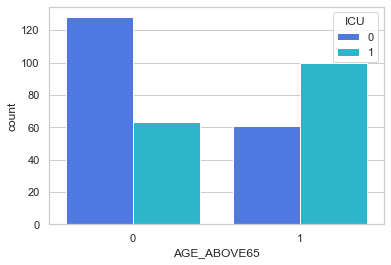

In [36]:
ax = sns.countplot(x="AGE_ABOVE65", hue="ICU", data=df_limpos)

No gráfico acima, percebemos uma frequência maior de pacientes que foram para a UTI com idade **acima de 65 cima (AGE_ABOVE65)**.

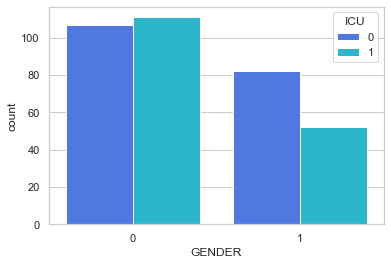

In [37]:
ax = sns.countplot(x="GENDER", hue="ICU", data=df_limpos)

No gráfico acima, percebemos uma predominância do genêro Masculino em nosso dataframe, e que a frequência dentre os homens que foram para UTI superou um pouco dos que não foram **(GENDER igual 0)**. Comparado ao gênero Feminino, os homens estão bem na frente!

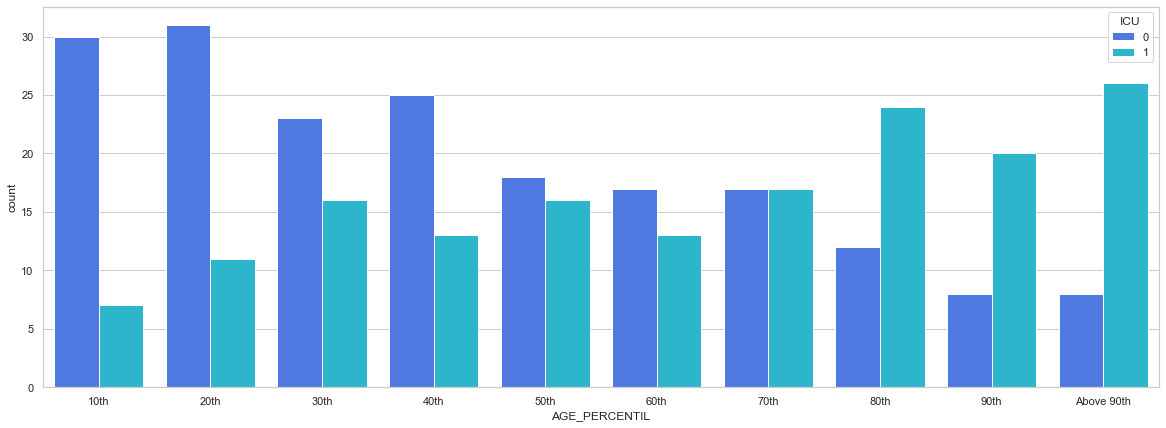

In [38]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.countplot(x='AGE_PERCENTIL',hue='ICU',data=df_limpos.sort_values(by='AGE_PERCENTIL'))
plt.show()

O gráfico acima evidencia a análise feita anteriormente: quanto **mais idade o paciente tem**, maior é a tendência de parar na UTI.

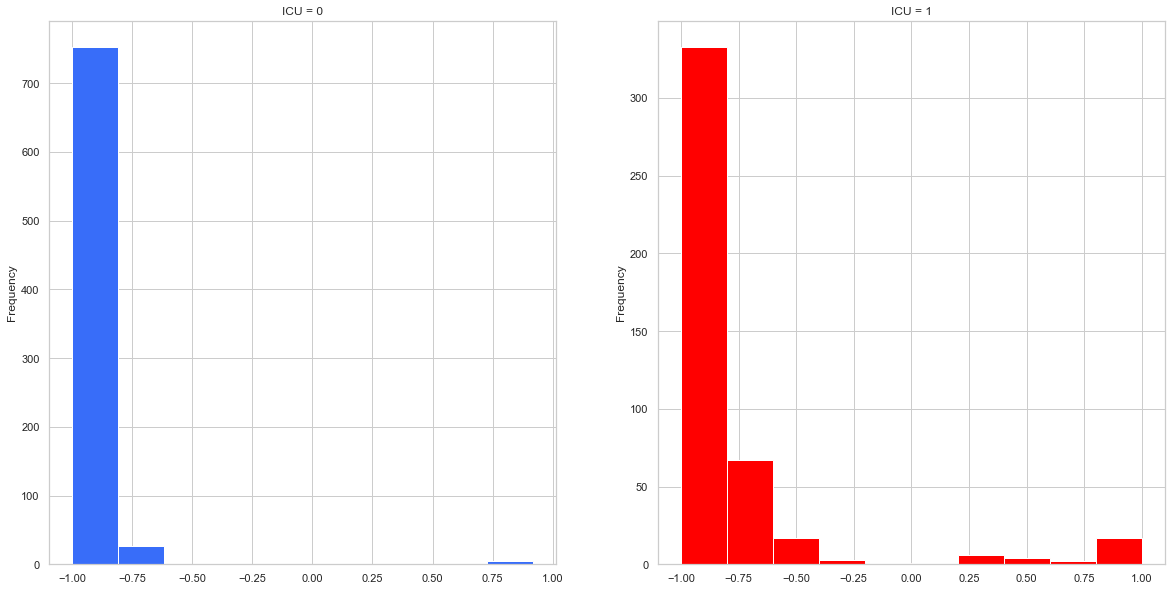

In [39]:
f,ax=plt.subplots(1,2,figsize=(20,10))
df[df['ICU']==0].OXYGEN_SATURATION_DIFF.plot.hist(ax=ax[0])
ax[0].set_title('ICU = 0')
df[df['ICU']==1].OXYGEN_SATURATION_DIFF.plot.hist(ax=ax[1], color='red')
ax[1].set_title('ICU = 1')
plt.show()

Nos gráficos do histograma acima, onde plotamos os valores da **diferença entre o máximo e o mínimo** das saturações do oxigênio aferidas (OXYGEN_SATURATION_DIFF), percebemos uma dispensão maior para os pacientes que foram para UTI.

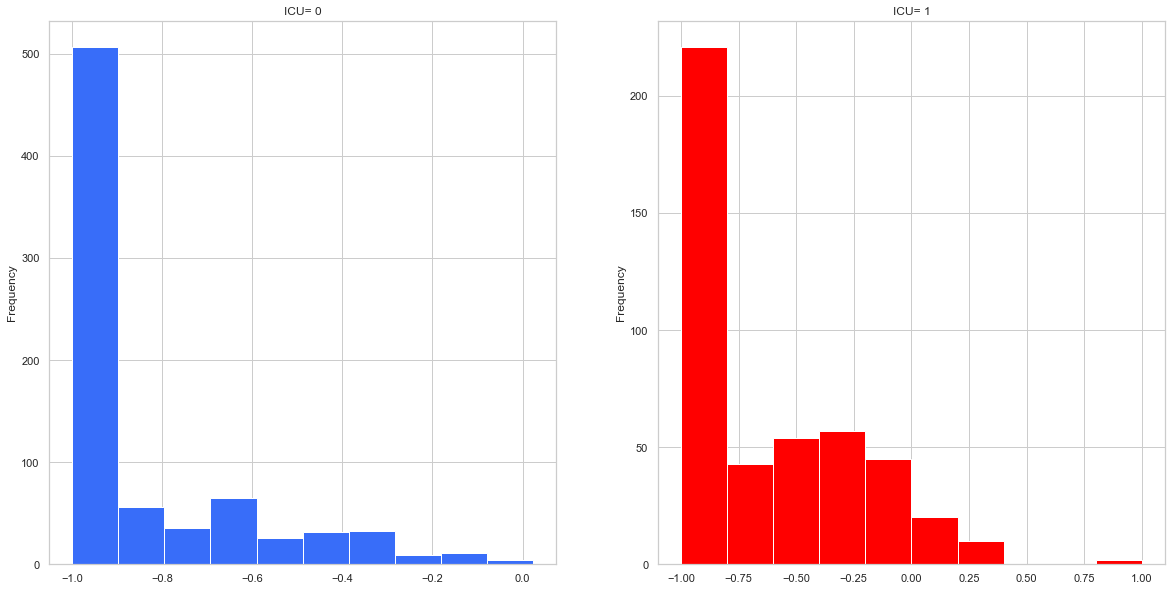

In [40]:
f,ax=plt.subplots(1,2,figsize=(20,10))
df[df['ICU']==0].TEMPERATURE_DIFF.plot.hist(ax=ax[0])
ax[0].set_title('ICU= 0')
df[df['ICU']==1].TEMPERATURE_DIFF.plot.hist(ax=ax[1],color='red')
ax[1].set_title('ICU= 1')
plt.show()

Nos gráficos de histograma acima, onde plotamos os valores da **diferença entre o máximo e o mínimo** das temperaturas aferidas (TEMPERATURE_DIFF), percebemos uma dispensão menor, porém, uma frequência maior de pacientes com **maiores variações entre a temperatura máxima e mínima**, para os pacientes que foram para a UTI.

### 3.7. Conclusões

Para a conclusão, vamos responder as hipóteses levantadas utilizadas como guia para o desenvolvimento da análise exploratória:

1. <font color='red'><b> Pessoas com mais idade tem mais tendência a ir para a UTI?</b></font>
    
    **Podemos concluir nas análises feitas que os pacientes com mais idade têm uma tendência maior de serem internados na UTI. Visualizamos nos gráficos relplot e countplot que váriaveis relacionadas à idade do paciente como (AGE_PERCENTIL e AGE_ABOVE65), podem influenciar positivamente na acuracidade do nosso modelo preditivo.**
    
    
2. <font color='red'><b> Qual grupo de risco é mais propenso? </b></font>

    **Podemos inferir com as análises feitas que pacientes que fazem parte do grupo de doenças 4 (DISEASE GROUPING 4) têm uma tendência maior de serem internados na UTI. Chegando a 89% (em média) de chances de parar na UTI, quando estão a mais de 12 horas de internação.**


3. <font color='red'><b> Existe um genêro predominante de pacientes indo para a UTI? </b></font>

    **Podemos concluir nas análise feitas que pacientes do gênero Masculino têm uma tendência maior de serem internados na UTI. Chegando a 56% (em média) de chances de parar na UTI. Ou seja, comparado aos 44% de chances do gênero Feminino, os homens têm 12% a mais de serem internados na UTI.**
    
    
4. <font color='red'><b>Os resultados dos exames laboratoriais tem correlação com ida da pessoas para a UTI? </b></font> 
    
    **Na análise exploratória selecionamos somente as variáveis com a média dos resultados dos exames de sangue e dos sinais vitais, e verificamos com o método `corr` a correlação entre elas e também com o nosso target ICU. O resultado que tivemos foram duas variáveis com uma correlação moderada: RESPIRATORY_RATE_MEAN e LACTATE_MEAN**. 

## 4. Desenvolvimento de Modelo Preditivo

### 4.1. Importando bibliotecas

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix

In [42]:
df_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


### 4.2. Engenharia de recursos

Antes de utilizarmos os dados que tratamos na análise exploratória para treinamento do modelo, precisaremos fazer **engenharia de recursos** para que o nosso modelo possa lidar com os dados da **melhor forma possível** e por consequência, nos trazer **bons resultados**. 

Ao analisar os nossos dados, percebemos que já houve uma **normalização** feita pelo Hospital Sírio Libânes. Porém, a maioria dos modelos que existem, não sabem lidar com dados do **tipo texto**, então precisaremos tratar as **variáveis categóricas** (que estão em formato do tipo texto) ainda presentes em nosso modelo, como **AGE_PERCENTIL** e **WINDOW**. Para este tratamento podemos removê-los, caso sejam irrelevantes para o treinamento do modelo, ou transformá-los em colunas do tipo numéricas.

In [43]:
df_limpos['AGE_PERCENTIL'].unique()

array(['60th', '10th', '40th', '70th', '20th', '50th', '80th', '30th',
       '90th', 'Above 90th'], dtype=object)

In [44]:
df_limpos['WINDOW'].unique()

array(['0-2'], dtype=object)

Na análise exploratória, verificamos que a váriavel **AGE_PERCENTIL** que representa a **faixa etária** dos nossos pacientes é altamente relavante para a previsão, pois percebemos que quanto **mais idade** o paciente tem, **mais as chances** ele tem de ir para a UTI, por isso vamos mantê-la. Porém, a variável **WINDOW**, que representa a janela de tempo de internação do paciente, perde sua relevância, uma vez que selecionamos **somente a de 0-2 horas de período de internação**, por isso removeremos esta variável com o método ``drop`` do pandas. 

Quanto à variável **PATIENT_VISIT_IDENTIFIER**, também iremos removê-la, pois mesmo que ela seja numérica não trará nenhuma informação relevante para o treinamento.

In [45]:
df_limpos.drop(['PATIENT_VISIT_IDENTIFIER','WINDOW'], axis=1, inplace=True)

Existem várias maneiras de utilizar a váriável **AGE_PERCENTIL**, e transformar os dados do tipo texto para o tipo númerico. Para este projeto utilizaremos o **LabelEncoder do sklearn**, uma vez que existe uma **ordem/precedência** entre faixa etárias.

In [46]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df_limpos['AGE_PERCENTIL'] = labelencoder.fit_transform(df_limpos['AGE_PERCENTIL'])

Resultado da **engenharia de recursos**, transformando os dados do tipo texto em dados do tipo numérico utilizando o **LabelEncoder** na variável **AGE_PERCENTIL**:

In [47]:
df_limpos['AGE_PERCENTIL'].unique()

array([5, 0, 3, 6, 1, 4, 7, 2, 8, 9])

### 4.3. Separação dos dados

Como de praxe para o treinamento do modelo, precisamos separar os dados em duas váriaveis: 
- **X**: que representa os dados com as variáveis previsoras. Que são todas a váriaveis **menos a váriavel target ICU.**
- **y**: que representa os dados com a variável a ser prevista (1 para paciente que vai para a UTI, e 0 paciente que não vai para a UTI). - A nossa famosa váriavel target **ICU**.

In [48]:
X = df_limpos.drop('ICU',axis=1)
y = df_limpos['ICU']

Depois que separamos os dados em **X** e **y**, vamos dividí-los em novas váriaveis de **treino** e **teste**. Esse processo de organização de nossos dados é **essencial para confiabialidade do nosso modelo**, pois se usássemos as informações clínicas de pacientes, tanto para treinamento quanto para teste, a chance desse modelo ficar **enviesado** é alta. Ou seja, para garantir uma boa performance, precisamos testar nosso modelo com dados que ele não conhece. 

Com isso em mente, utilizamos um método `train_test_split` do `sklearn`, e separamos em dados de treino: **X_train** e **y_train**; e dados de teste: **X_test** e **y_test**.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [50]:
y.value_counts()

0    189
1    163
Name: ICU, dtype: int64

In [51]:
y_train.value_counts()

0    142
1    122
Name: ICU, dtype: int64

In [52]:
y_test.value_counts()

0    47
1    41
Name: ICU, dtype: int64

Depois da divisão dos dados, nossa base de pacientes que era **352**, ficou **264** para treino e **89** para teste. Ou seja, **25%** para teste e **75%** para treino. Quando não passamos o parâmetro para escolhermos essa divisão por padrão, o metódo `train_test_split` escolhe essa configuração de divisão de dados.

### 4.4. Treinamento do Modelo

Pronto! Enfim chegamos ao que interessa! Depois dos tratamentos nos dados, finalmente podemos treinar o nosso **modelo preditivo**. Mas antes, precisamos determinar um valor base de **acurácia** para saber se o nosso modelo está minimamente aceitável. 

Para isso, utilizaremos o **DummyClassifier**, este modelo consiste em "prever" (que na verdade é chutar) o target de acordo com a proporção. Isso significa que se nossos dados tiverem 60% classificados como 0, ele classificará **aleatóriamente** **60%** para 0 e **40%** para 1. Por este modelo ser tão simples, qualquer outro que utilizemos para previsão precisa ter um resultado melhor que o do **DummyClassifier**. 

Passo-a-passo para treinamento do modelo:

No linha de comando abaixo inicializamos o **modelo**.

In [53]:
modelo = DummyClassifier()

E em seguida, para treinar o nosso modelo, chamamos o método `fit` passando os dados de treino **X_train** e **y_train**.

In [54]:
modelo.fit(X_train, y_train)

DummyClassifier()

**Pronto! Modelo treinado! Simples não?!**

Com o modelo treinado, podemos extrair as previsões com o método `predict` informando os dados de teste **X_test.**

In [55]:
previsao = modelo.predict(X_test)

In [56]:
accuracy_score(y_test, previsao)

0.5340909090909091

Ao treinar nossos dados com o modelo **DummyClassifier**, obtemos o resultado de **53% de acurácia** com método `accuracy_score`. Quer dizer que, a partir de agora, a acurácia dos próximos modelos que treinaremos precisa ser melhor.

A partir de agora vamos começar a utilizar modelos que (teoricamente) deverão ser mais eficientes que o **DummyClassifier (classificador fictício)**, pois precisamos entregar um modelo que consiga prever se os pacientes vão parar na UTI com uma **boa eficiência**.

O primeiro que utilizaremos é: **Regressão Logística**

Modelo muito usado para resolver problemas de **regressão**, que são modelos desenvolvidos para prever **targets númericos** (o preço de uma casa, por exemplo). Ele também é muito usado para resolver problemas de **Classificação Binária**, que é o nosso caso.

Segue um [link](https://matheusfacure.github.io/2017/02/25/regr-log/) de um artigo muito interessante para entendimento sobre Regressão Logística.

In [57]:
log_reg = LogisticRegression()

In [58]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [59]:
previsao = log_reg.predict(X_test)
accuracy_score(y_test, previsao)

0.7159090909090909

Ao utilizar a **Regressão Logística**, percebemos uma evolução na acurácia com relação a **DummyClassifier**. Obtivemos a **acurácia de 60%.** Com este resultado podemos concluir que esse modelo pode ser uma boa opção, mas devido à importância do nosso projeto precisamos analisar outras métricas para garantir a sua boa performance na **vida real**. 

Para analisar a performace do nosso modelo, inicialmente utilizaremos o recurso do sklearn chamado Relatório de Classficação (classification_report).

As métricas do **relatório de classificação** do sklearn, utilizam os conceitos estatíticos de **Verdadeiro Positivo (VP), Verdadeiro Negativo (VN), Falso Positivo(FP) e Falso Negativo(FN)** para contabilizar os erros e acertos, e assim demostrarmos em números a qualidade do nosso modelo. As métricas produzidas neste relatório são:

   - **Precision (Precisão):** VP / (VP + FP)
   - **Recall:** VP / (VP + FN)
   - **F1-score:** Média harmônica ponderada de precisão e recall, onde uma pontuação F1-score atinge seu melhor valor em 1 e a pior pontuação em 0.

Ao gerar o **relatório de classificação** comparando previsão com os dados reais, obtemos o seguinte resultado:

In [60]:
print(classification_report(y_test,previsao))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74        47
           1       0.71      0.66      0.68        41

    accuracy                           0.72        88
   macro avg       0.72      0.71      0.71        88
weighted avg       0.72      0.72      0.71        88



- A **precisão** da nossa previsão para quem vai para UTI foi **58%**, e para quem não vai é **62%**.
- O **recall** da nossa previsão para quem vai para UTI foi **51%**, e para quem não vai é de **68%**.

Para entender melhor esses resultados podemos utilizar a **matrix de confusão**, neste gráfico podemos extrair os números para calcular a precisão e o recall.

<img src="https://github.com/diogoslz/Bootcamp-Alura-Modulo-Projeto-final/blob/main/Notebooks/matrix%20confus%C3%A3o.PNG?raw=true">

- **Verdadeiros Positivos (VP, em inglês TP)** são pacientes que **foram para a UTI** e o valor previsto é **positivo**, isto é, o modelo acertou. (ICU = 1 e Previsto = 1).
- **Verdadeiros Negativos (VN, em inglês TN)** são pacientes que **não foram para a UTI** e o valor previsto é **negativo**, isto é, o modelo acertou (ICU = 0 e Previsto = 0).
- **Falsos Positivos (FP)** são pacientes que **não foram para a UTI** entretanto o resultado obtido é **positivo**, isto é, o modelo errou (ICU = 0 e Previsto = 1).
- **Falsos Negativos (FN)** são pacientes que **foram para a UTI** entretanto o resultado obtido é **negativo**, isto é, o modelo errou (ICU = 1 e Previsto = 0).

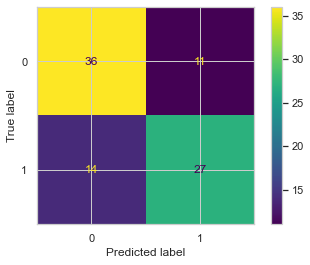

In [61]:
plot_confusion_matrix(log_reg, X_test, y_test)

Ao gerar o gráfico de **matrix de confusão** do nosso modelo utilizando os nossos dados de testes, podemos extrair os seguintes resultados:

- **Total de Verdadeiro Positivo: 21**
- **Total de Verdadeiro Negativo: 32**
- **Total de Falso Positivo: 20**
- **Total de Falso Negativo: 15**

Em posse desses resultados, podemos utilizá-los para calculá-los utilizando a fórmula de cálculos utilizada no **relatório de classificação**, e com isso, entendermos melhor nossas métricas:

In [62]:
VP = 21
VN = 32
FP = 15
FN = 20

In [63]:
precision = VP / (VP + FP)
recall = VP / (VP + FN)

In [64]:
precision

0.5833333333333334

In [65]:
recall

0.5121951219512195

Ao calcularmos esses resultados extraídos da **matriz confusão**, conseguimos entender com mais propriedade o cálculo do relatório de classficação. Pois o resultado da **precisão e recall** é o mesmo que foi extraído do relatório.

Mas vamos parar pra pensar um pouco: Quais desses tipos de métricas podem avaliar melhor os resultados obtidos para este projeto? **Precision** ou **Recall**? 

No nosso caso, o que seria pior? O modelo prever se o paciente vai para UTI e ele na realidade não precisar? Ou prever se ele não precisa ir para UTI, mas na realidade ele precisava? Com certeza a segunda opção: **O Falso Negativo**. Nesse caso, podemos deduzir que o tipo da métrica que melhor pode avaliar nosso modelo é o **Recall**, pois o **FN** tem peso no seu cálculo.

Outra métrica que pode nos ajudar na avaliação é **AUC(Area Under Curve ou Área sob a curva)**. Esta métrica sintetiza os resultados de **acertos e erros da matriz de confusão**, pois o cálculo é feito com base na **taxa de falsos negativos e na taxa de falsos positivos**.

Para melhor entendimento sobre esta métrica, segue abaixo o trecho de um artigo muito bom sobre **Matriz de Confusão e AUC ROC do [Marcos Silva](https://medium.com/data-hackers/matriz-de-confus%C3%A3o-e-auc-roc-f7e446dca107)**.

>**Mas afinal de contas o que é essa AUC.**

>Cada extremidade da curva ROC é formada por um limite escolhido. O exemplo abaixo nos ajuda a entender. Imagine que começamos com o corte de 20% e observamos a taxa de falsos negativos e a taxa de falsos positivos, e avançamos nos diferentes limites para formar a curva. Na prática, quando pedimos ao sklearn para plotar a curva ROC, ele faz essa observação da seguinte maneira:

<img src="https://miro.medium.com/max/885/0*TkCTYT87YmPwZ8W2.png">

>- Calcula as chances da classe ser verdadeira. P (y = 1)
>- Classifica da maior probabilidade para a menor probabilidade.
>- Começa no canto esquerdo, se a observação mais provável estiver correta, vai para cima, se estiver errada, vai para a direita.
>- Após repetir esse processo para todas as observações, temos a curva ROC.
>- Calculamos AUC como a área abaixo da curva ROC.

>A AUC nada mais é do que a área que se forma abaixo da curva ROC, mas traz interpretações muito interessantes.

Em seguida, vamos testar outros algoritmos que possa de "encaixar" melhor que a Regressão Logística, e conseguimos resultados melhores.

Selecionamos mais 4 algoritmos, além da Regressão Logística, para esta comparação:
- **KNN (k-nearest neighbors)**
- **Foresta Aleatória**
- **Árvore de Decisão**
- **Gradient Boosting**

Inicialmente, criamos abaixo uma lista com esses modelos.

In [66]:
modelos = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBClassifier": XGBClassifier(eval_metric='mlogloss')
}

Em seguinda criamos o método `roda_modelos` em que itera sobre a lista de modelos, treinando cada um deles com os nossos dados de treino e imprimindo o relatório de classificação logo em seguida para avaliá-los.

In [67]:
def roda_modelos(modelos, dados):
    
    y = dados["ICU"]
    X = dados.drop(["ICU"], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    
    for nome_modelo, modelo in modelos.items():

        modelo.fit(X_train, y_train)
        predicao = modelo.predict(X_test)
        prob_predic = modelo.predict_proba(X_test)
        
        auc = roc_auc_score(y_test, prob_predic[:,1])
        print(f"AUC {auc}")
        print("\nClassification Report - " + nome_modelo)
        print(classification_report(y_test, predicao))

In [68]:
roda_modelos(modelos, df_limpos)

AUC 0.751946030098599

Classification Report - LogisticRegression
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        47
           1       0.75      0.59      0.66        41

    accuracy                           0.72        88
   macro avg       0.72      0.71      0.71        88
weighted avg       0.72      0.72      0.71        88

AUC 0.7280747275557862

Classification Report - KNearest
              precision    recall  f1-score   support

           0       0.59      0.85      0.70        47
           1       0.65      0.32      0.43        41

    accuracy                           0.60        88
   macro avg       0.62      0.58      0.56        88
weighted avg       0.62      0.60      0.57        88

AUC 0.7872340425531915

Classification Report - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        47
           1       0.78      0.76      0.77

Ao analisar os resultados, percebemos que dois modelos tiveram os melhores resultados: 
- **Gradient Boosting** (XGBClassifier): **83% de Recall e 80% de AUC**;
- **Foresta Aleatória** (RandomForestClassifier): **80% de Recall** e **82% de AUC**. 

Agora temos dois bons candidatos (que fazem jus a sua fama)!

Porém, precisamos seguir mais alguns passos para refinar mais nossos modelos, para garantir a **boa qualidade da nossa entrega para o Hospital Sírio Libanês.**

Antes de continuar, uma questão que devemos nos preocupar, é o **efeito da aletoriedade** para que não tomemos uma decisão equivocada na busca do melhor modelo. Esse efeito ocorre durante a divisão dos dados em **treino e teste (`train_test_split`)**.

Para minimizar esse efeito criaremos o `roda_n_modelos`. Onde esse método rodará **n vezes**, e cada vez que ele roda, armazena o resultado da métrica **AUC** numa lista. E a partir dessa lista, calculamos o seu **desvio padrão (std), média e seu intervalo**.

In [69]:
def roda_n_modelos(nome_modelo, modelo, dados, n):

    y = dados["ICU"]
    X = dados.drop("ICU", axis=1)
    
    auc_lista = []
    for _ in range(n):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

        modelo.fit(X_train, y_train)
        prob_predic = modelo.predict_proba(X_test)
        auc = roc_auc_score(y_test, prob_predic[:,1])
        auc_lista.append(auc)
    
    auc_medio = np.mean(auc_lista)
    auc_std = np.std(auc_lista)
    print(f"Modelo: {nome_modelo}")
    print(f"AUC {auc_medio}")
    print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio + 2* auc_std}")

In [70]:
for nome_modelo, modelo in modelos.items():
    roda_n_modelos(nome_modelo, modelo, df_limpos, 50)

Modelo: LogisticRegression
AUC 0.7640788790866633
Intervalo 0.6838705155393323 - 0.8442872426339942
Modelo: KNearest
AUC 0.6892423456149456
Intervalo 0.5817931286468787 - 0.7966915625830124
Modelo: RandomForestClassifier
AUC 0.7972236637259988
Intervalo 0.7179266900706858 - 0.8765206373813119
Modelo: DecisionTreeClassifier
AUC 0.6278567721847432
Intervalo 0.5200768338842297 - 0.7356367104852568
Modelo: XGBClassifier
AUC 0.7922781525687597
Intervalo 0.6978358344593892 - 0.8867204706781301


Ao executar esse método para avaliar o **AUC** do nossos modelos, percebemos uma mudança em nossos resultados:

- **Regressão Logística** saiu de **79%** para **75%**
-  **KNN** saiu de **68%** para **69%**
- **Foresta Aleatória** saiu de **82%** para **77%**
- **Arvore de Decisão** saiu de **64%** para **62%**
- **Gradient Boosting** saiu de **80%** para **77%**

Para compreender melhor o efeito da **aletoriedade** na divisão dos dados pelo `train_test_split`, retornamos também os intervalos entre o menor e o maior dos resultados das métricas obtidos em cada iteração:

- **Regressão Logística**: minimo **66%**, máximo **84%**.
-  **KNN**: minimo **60%**, máximo **79%**.
- **Foresta Aleatória**: minimo **68%**, máximo **87%**.
- **Arvore de Decisão**: minimo **52%**, máximo **73%**.
- **Gradient Boosting**: minimo **69%**, máximo **85%**.

Analisando esses resultados, podemos concluir que os algoritmos **Foresta Aleatória** e **Gradient Boosting** continuam na dianteira em comparação aos outros modelos, empatados com **77% de AUC**. 

Mas existe uma estratégia mais inteligente de separação dos nossos dados em **treino e teste** que vai reduzir muito mais o **efeito da aletoriadade**; utilizaremos o **Cross Validation**. E para complementar essa nossa estratégia, utilizaremos **RepeatedStratifiedKFold**

- **RepeatedStratifiedKFold**: Esta função estratifica nossos dados n vezes e garante que a divisão em dados de treino e testes do Cross Validade seja feita de forma proporcial, reduzindo efeito do desbalanciamento dos dados (mais pacientes que não foram para UTI ou vice-versa, por exemplo) no momento da passagem desses dados no treinamento do modelo.

Para melhor entendimento sobre **Cross Validation**, segue abaixo o trecho de um excelente artigo do **[Eduardo Braz Rabello](https://medium.com/@edubrazrabello/cross-validation-avaliando-seu-modelo-de-machine-learning-1fb70df15b78)**:

> **O que é Cross Validation (CV)**

> Cross Validation é uma técnica muito utilizada para avaliação de desempenho de modelos de aprendizado de máquina. O CV consiste em particionar os dados em conjuntos(partes), onde um conjunto é utilizado para treino e outro conjunto é utilizado para teste e avaliação do desempenho do modelo. A utilização do CV tem altas chances de detectar se o seu modelo está sobreajustado aos seus dados de treinamento, ou seja, sofrendo overfitting. Existem mais de um método de aplicação de CV, nesse artigo estarei focando nos métodos K-fold.

> **K-fold Cross Validation**

> K-fold consiste em dividir a base de dados de forma aleatória em K subconjuntos (em que K é definido previamente) com aproximadamente a mesma quantidade de amostras em cada um deles. A cada iteração, treino e teste, um conjunto formado por K-1 subconjuntos são utilizados para treinamento e o subconjunto restante será utilizado para teste gerando um resultado de métrica para avaliação (ex: acurácia). Esse processo garante que cada subconjunto será utilizado para teste em algum momento da avaliação do modelo.

<img src="https://miro.medium.com/max/3600/1*kkMtezwv8qj1t9uG4nw_8g.png">


> Vamos levar em consideração um cenário de 5-fold cross validation. Os dados serão divididos em 5 partes. Na primeira iteração a primeira parte será utilizada para teste e as partes restantes serão utilizadas para treinamento do modelo gerando uma métrica de avaliação. Na segunda iteração, a segunda parte será utilizada para teste enquanto as demais para treino. Esse processo será repetido 5 vezes até que toda a base passe pelo processo de treino e teste gerando uma métrica de avaliação média para o modelo, conforme a imagem acima.

Pronto! Com essas melhorias no processo de treinamento do modelo preditivo criamos um método chamado `roda_modelo_cv`: 

In [71]:
def roda_modelo_cv(nome_modelo, modelo, dados, n_splits, n_repeats):

    np.random.seed(3454)
    dados = dados.sample(frac=1).reset_index(drop=True)
    y = dados["ICU"]
    X = dados.drop("ICU", axis=1)
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, X, y, cv=cv, scoring='roc_auc', return_train_score=True)

    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])
    
    print(f"Modelo: {nome_modelo}")
    print(f'AUC  {auc_medio}')
    return auc_medio, auc_medio_treino

In [72]:
for nome_modelo, modelo in modelos.items():
    roda_modelo_cv(nome_modelo, modelo, df_limpos, 5, 50)

Modelo: LogisticRegression
AUC  0.7595077347083927
Modelo: KNearest
AUC  0.6908415139122376
Modelo: RandomForestClassifier
AUC  0.7912318162959611
Modelo: DecisionTreeClassifier
AUC  0.62911075369628
Modelo: XGBClassifier
AUC  0.7853932470149575


Ao executar esse método para avaliar o **AUC** do nossos modelos, percebemos que não houveram muitas mudanças, mas agora temos mais garantia que reduzimos o máximo o **efeito da aleatoridade** em nossos resultados:

- **Regressão Logística** continuou **75%**
- **KNN** continuou **69%**
- **Foresta Aleatória** melhorou! Passou de **77%** para **79%**
- **Arvore de Decisão** continuou **62%**
- **Gradient Boosting** melhorou um pouco, passou **77%** para **78%**

Tem mais um recurso dos nossos modelos que ainda não exploramos, e que podemos utilizar para otimizar nosso modelo e melhorar os resultados. Usaremos os **hiperparametros**. E para nos apoiar nesse processo, utilizaremos o **Randomizedsearch** do Sklearn. 

O **randomizedsearch**, como o nome já diz, ele faz uma procura numa **grid de hiperparametros de maneira aleatória**, para encontrar os melhores parametros que otimizam os estimadores dos nossos modelo com base no score que selecionamos (no nosso caso é o AUC).

Para melhor entendimento sobre o **Randomizedsearch**, a Alura tem um material muito bom sobre este assunto neste [link](https://www.alura.com.br/conteudo/machine-learning-otimizacao-com-exploracao-aleatoria?gclid=CjwKCAjw3riIBhAwEiwAzD3Tic0g7xBSK5NKLAFrQhfocCewKdZ9uVx3m3TrjvUkfHlc2SjcsoVEMRoCVTAQAvD_BwE)

In [73]:
def roda_modelo_cv_randomizedsearch(nome_modelo, modelo, dados, n_splits, n_repeats):

    np.random.seed(3454)
    dados = dados.sample(frac=1).reset_index(drop=True)
    y = dados["ICU"]
    X = dados.drop("ICU", axis=1)
    
    if (nome_modelo == "RandomForestClassifier") :
        params = {
            'bootstrap': [True],
            'max_depth': list(range(2,5,1)),
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 200, 300, 1000]
            }
    elif (nome_modelo == "XGBClassifier") :
        params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': list(range(2,5,1))
            }
    elif (nome_modelo == "LogisticRegression") :
        params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    elif (nome_modelo == "KNearest") :
        params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
        
    elif (nome_modelo == "DecisionTreeClassifier") :
        params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}
        
        
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    
    grid = RandomizedSearchCV(modelo, params, cv=cv, scoring='roc_auc')
    grid.fit(X, y)
    
    modelo = grid.best_estimator_
    
    resultados = cross_validate(modelo, X, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])
    
    print(f"Modelo: {nome_modelo}")
    print(f'AUC  {auc_medio}')
    return modelo

In [74]:
modelos_tunados = []
for nome_modelo, modelo in modelos.items():
    modelos_tunados.append(roda_modelo_cv_randomizedsearch(nome_modelo, modelo, df_limpos, 5, 10))

Modelo: LogisticRegression
AUC  0.7519698855554118
Modelo: KNearest
AUC  0.6779958591965172
Modelo: RandomForestClassifier
AUC  0.7987433456183456
Modelo: DecisionTreeClassifier
AUC  0.6879869283158756
Modelo: XGBClassifier
AUC  0.7909896574205786


Ao executar esse método para avaliar o **AUC** do nossos modelos, percebemos não houveram muitas mudanças, mas melhorou nos nossos melhores modelos: 

- **Foresta Aleatória**: Melhorou **3%**, ficando com **80%**.
- **Gradient Boosting**: Melhorou **2%**, ficando com **79%**.

In [75]:
modelos_tunados

[LogisticRegression(C=0.01),
 KNeighborsClassifier(algorithm='kd_tree', n_neighbors=4),
 RandomForestClassifier(max_depth=4, max_features=3, min_samples_leaf=4,
                        min_samples_split=10, n_estimators=1000),
 DecisionTreeClassifier(max_depth=3, min_samples_leaf=6),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.6, eval_metric='mlogloss',
               gamma=0.5, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=0.8, tree_method='exact',
               validate_parameters=1, verbosity=None)]

Acima podemos visualizar como ficou a configuração dos hiperparametros dos nossos modelos depois da otimização com **RandomizedSearchCV**.

Vamos selecionar o modelo que desempenhou melhores resultados com os nossos testes: **RandomForestClassifier**

In [76]:
melhor_modelo = modelos_tunados[2]
melhor_modelo

RandomForestClassifier(max_depth=4, max_features=3, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000)

Agora que já temos nosso modelo, podemos avaliar as váriaveis altamente correlacionadas analisas na **Análise Explorátoria**. Por exemplo: Se removêssemos o **AGE_ABOVE65 ou AGE_PENCENTIL**. 

**Qual seria o impacto disso no resultado do nosso modelo?** 

Vamos utilizar o método `corr` somente nessas variáveis para verificar sua **correlação**.

In [77]:
df_limpos[['AGE_ABOVE65', 'AGE_PERCENTIL']].corr()

,AGE_ABOVE65,AGE_PERCENTIL
AGE_ABOVE65,1.000000,0.874773
AGE_PERCENTIL,0.874773,1.000000


Observando resultado gerado, obtivemos o valor **p = 0,87**, isso implica em **correlação forte** entre elas.

Com isso em mente, vamos criar mais um dataframe **sem uma dessas variaveis**.

In [78]:
df_limpos_age_percentil = df_limpos.drop('AGE_PERCENTIL', axis=1)

Agora vamos executar o `roda_modelo_cv_randomizedsearch` para avaliar o impacto da **falta da váriavel AGE_PERCENTIL**.

In [79]:
roda_modelo_cv_randomizedsearch("RandomForestClassifier", melhor_modelo, df_limpos_age_percentil, 5, 10)

Modelo: RandomForestClassifier
AUC  0.7944302690848742


RandomForestClassifier(max_depth=4, max_features=3, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000)

In [80]:
for nome_modelo, modelo in modelos.items():
    roda_modelo_cv_randomizedsearch(nome_modelo, modelo, df_limpos_age_percentil, 5, 10)

Modelo: LogisticRegression
AUC  0.765040815336868
Modelo: KNearest
AUC  0.6633658508987458
Modelo: RandomForestClassifier
AUC  0.7944302690848742
Modelo: DecisionTreeClassifier
AUC  0.668268958252511
Modelo: XGBClassifier
AUC  0.7834790292685028


Analisando o resultado acima, percebemos que quase não houve impacto na ausência da váriavel **AGE_PERCENTIL** no nosso modelo. **O AUC da Foresta Aleatória se manteve próximo dos 80%**. Podemos concluir nesse teste que variáveis altamente correlacionadas tendem a **não contribuir muito**. Isso quer dizer que você pode manter **apenas uma das variáveis**. 

Para isso criaremos o metodo `remove_corr_var`, onde passaremos o nosso **df_limpos** e um valor de corte.

In [81]:
def remove_corr_var(dados, valor_corte):

    matrix_corr = dados.iloc[:,4:-2].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
    excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]

    return dados.drop(excluir, axis=1)

In [82]:
df_limpos_sem_corr = remove_corr_var(df_limpos, 0.95)

In [83]:
len(df_limpos.columns)

229

In [84]:
len(df_limpos_sem_corr.columns)

99

Depois que executamos o `remove_corr_var`, conseguimos reduzir nosso **df_limpos** de **229 variáveis** para **99**

In [85]:
roda_modelo_cv_randomizedsearch("RandomForestClassifier", melhor_modelo, df_limpos_sem_corr, 5, 10)

Modelo: RandomForestClassifier
AUC  0.8055295890986679


RandomForestClassifier(max_depth=4, max_features=3, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000)

Ótimo! Conseguimos manter o resultado de **80% de AUC** reduzindo de **229** para **99 váriaveis**.

## 5. Conclusões

Este projeto se mostrou muito desafiador, com certeza devido a sua grande importância: Desenvolver um modelo preditivo para prever quais pacientes com COVID-19 precisarão ser admitidos na UTI. O hospital **Sírio Libanês** nos disponibilizou dados faltando muita informação clínicas, mas conseguimos contornar essa situação com `ffill` e `bfill`. Este foi o ponto de partida para fazer a análise exploratória, a partir desta analise conhecer melhor nossos dados e com isso, desenvolver um modelo que possa satisfazer nosso cliente.

## 6. Referências

- [Alura](https://www.alura.com.br/);
- [Regressão Logística](https://matheusfacure.github.io/2017/02/25/regr-log/)
- [Dinesh Yadav](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)
- [Towards Data Science](https://towardsdatascience.com);
- [Medium](https://medium.com/);
- [Amanda Munari Guimarães](https://medium.com/omixdata/estat%C3%ADstica-an%C3%A1lise-de-correla%C3%A7%C3%A3o-usando-python-e-r-d68611511b5a);
- [Bootcamp Data Science Aplicada](https://www.alura.com.br/bootcamp/data-science-aplicada/matriculas-abertas);
- [Storytelling with Data](https://www.storytellingwithdata.com/);
- [Seaborn](https://seaborn.pydata.org/);
- [Numpy](https://numpy.org/](https://numpy.org/);
- [Pandas](https://pandas.pydata.org/](https://pandas.pydata.org/);
- [Matplotlib](https://matplotlib.org/](https://matplotlib.org/)
- [Marcos Silva](https://medium.com/data-hackers/matriz-de-confus%C3%A3o-e-auc-roc-f7e446dca107)
- [Eduardo Braz Rabello](https://medium.com/@edubrazrabello/cross-validation-avaliando-seu-modelo-de-machine-learning-1fb70df15b78)
- [Machine Learning parte 2: Otimização com exploração aleatória](https://www.alura.com.br/conteudo/machine-learning-otimizacao-com-exploracao-aleatoria?gclid=CjwKCAjw3riIBhAwEiwAzD3Tic0g7xBSK5NKLAFrQhfocCewKdZ9uVx3m3TrjvUkfHlc2SjcsoVEMRoCVTAQAvD_BwE)

## 7. Contatos

Alguma dica, dúvida ou sugestão? Fique à vontade para contatar:

- https://www.linkedin.com/in/diogo-miranda-de-azevedo-63758425/
- https://github.com/diogoslz
- diogonick@gmail.com